# Edi06 - Nitrogen quantitative analyses

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set up to find custom python package
import os
import sys
import numpy as np
sys.path.insert(1, ".")
sys.path.insert(1, "..")

In [3]:
from src import readfiles, wdscan, correct_quant, calczaf, helper_funs
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from nb_helper_funs import compile_n_summary

np.random.seed(42)

# Quantitative analysis

In [4]:
sample = 'Edi06'
sample_folders = [Path(f'../data/raw/basaltic_glasses_StA/raw_quant_by_sample/{sample}/')]
# List of folders corresponding to the samples
category = 'basaltic glasses' # Category of this dataset (e.g. "glasses")
wd_scan = Path(f'../data/interim/basaltic_glasses/fits/key_params_{sample}.txt') # Path to wd scan fit parameters
std_dbase_info_file = Path('data/_dictionaries/standards.csv')

In [5]:
datalist = readfiles.find_files_and_folders(
                [sample], sample_folders,
                # apf_file = None,
                apf_file=Path('../data/_dictionaries/apf_values.csv'), #<- Can put None in here
                wd_scan=wd_scan
                )

datalist

Comments found: ['Edi06_100nA_30um_1', 'Edi06_100nA_30um_2', 'Edi06_100nA_30um_3', 'Edi06_100nA_30um_4', 'Edi06_100nA_30um_5']


,folder,comment,sample,paramfile,apf,apf_sd
0,..\data\raw\basaltic_glasses_StA\raw_quant_by_...,Edi06_100nA_30um_1,Edi06,..\data\interim\basaltic_glasses\fits\key_para...,0.83,0.03
1,..\data\raw\basaltic_glasses_StA\raw_quant_by_...,Edi06_100nA_30um_2,Edi06,..\data\interim\basaltic_glasses\fits\key_para...,0.83,0.03
2,..\data\raw\basaltic_glasses_StA\raw_quant_by_...,Edi06_100nA_30um_3,Edi06,..\data\interim\basaltic_glasses\fits\key_para...,0.83,0.03
3,..\data\raw\basaltic_glasses_StA\raw_quant_by_...,Edi06_100nA_30um_4,Edi06,..\data\interim\basaltic_glasses\fits\key_para...,0.83,0.03
4,..\data\raw\basaltic_glasses_StA\raw_quant_by_...,Edi06_100nA_30um_5,Edi06,..\data\interim\basaltic_glasses\fits\key_para...,0.83,0.03


In [6]:
myspot = [None] * len(datalist.folder)

for i in range(len(datalist.folder)):
    peak, bg, standard, info = readfiles.read_and_organise_data(
                                    datalist.loc[i,:].copy(),
                                    bgi=False,
                                    save=False)
    myspot[i] = correct_quant.Spot()
    myspot[i].add_data(info, bg, peak, standard)
    myspot[i].add_wd_scan_params_from_file(wd_scan)
    print('Read dataset:', i + 1, 'of', len(datalist), ':',
          myspot[i].info.comment)
    myspot[i].comprehensify_data()


 loading path: ..\data\interim\basaltic_glasses\fits\key_params_Edi06.txt
{'sigma': 0.06632317632686768, 'center': 108.2852534237461}
Read dataset: 1 of 5 : Edi06_100nA_30um_1

 loading path: ..\data\interim\basaltic_glasses\fits\key_params_Edi06.txt
{'sigma': 0.06632317632686768, 'center': 108.2852534237461}
Read dataset: 2 of 5 : Edi06_100nA_30um_2

 loading path: ..\data\interim\basaltic_glasses\fits\key_params_Edi06.txt
{'sigma': 0.06632317632686768, 'center': 108.2852534237461}
Read dataset: 3 of 5 : Edi06_100nA_30um_3

 loading path: ..\data\interim\basaltic_glasses\fits\key_params_Edi06.txt
{'sigma': 0.06632317632686768, 'center': 108.2852534237461}
Read dataset: 4 of 5 : Edi06_100nA_30um_4

 loading path: ..\data\interim\basaltic_glasses\fits\key_params_Edi06.txt
{'sigma': 0.06632317632686768, 'center': 108.2852534237461}
Read dataset: 5 of 5 : Edi06_100nA_30um_5


In [7]:
correct_quant.process_datasets(
    myspot, 
    datalist, 
    num_mc_sims=100, 
    path_out=Path(f"../data/processed/basaltic_glasses/background_corrections/{sample}")
    )


Processing dataset: 1 of 5 : Edi06_100nA_30um_1
Correcting background
Saved bg correction figure for 2021-12-22_Edi06_100nA_30um_1
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2021-12-22_Edi06_100nA_30um_1
correct height/area ratio
original kraw: 0.00 ± 100.00%
corrected kraw: 0.00 ± 2062.87%

Processing dataset: 2 of 5 : Edi06_100nA_30um_2
Correcting background
Saved bg correction figure for 2021-12-22_Edi06_100nA_30um_2
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2021-12-22_Edi06_100nA_30um_2
correct height/area ratio
original kraw: 0.00 ± 100.00%
corrected kraw: 0.09 ± 73.37%

Processing dataset: 3 of 5 : Edi06_100nA_30um_3
Correcting background
Saved bg correction figure for 2021-12-22_Edi06_100nA_30um_3
Resample cps to check stdev method
Montecarl

## Write calczaf file

In [8]:
samples = [sample]
category = 'basaltic glasses'
subfolder = Path(f'../data/processed/basaltic_glasses/calczaf_files/{sample}/')

write_detection_limit_calczaf_files = True
detlim_subfolder = subfolder / Path('detlim')

# note: in the subfolder there must be a file specifying valence.
# this can be copied from the _dictionaries folder.
valence_dict = readfiles.read_valence_file(subfolder, pattern='valence*')
standard_database_dict = pd.read_csv(
    '../data/_dictionaries/standards.csv',
     index_col=0, 
     header=None, 
     squeeze=True).to_dict()

standard_database_dict

{'Sanidine': 3000,
 'Diopside': 3001,
 '08_Pollucite': 3002,
 'Albite': 3003,
 'GaN': 608,
 '22_Mo': 542,
 '09_Vanadium_Wire_Alfa': 523,
 'BN': 604}

In [9]:
# Make a dictionary
sampledata = {sample: myspot}

Get the major element analyses

In [10]:
majors_summary = pd.read_csv(
    "../data/processed/basaltic_glasses/basaltic_glasses_majors_summary.csv",
    header = [0, 1], index_col=0)
majors_summary[sample]

,wt% mean,stdev (n=3)
Si,23.155,0.035
Al,7.739,0.056
Cl,0.003,0.003
P,0.085,0.003
Fe,6.087,0.057
Mn,0.265,0.007
Cr,0.034,0.008
K,0.173,0.004
Ca,10.639,0.011
Ru,0.009,0.016


In [11]:
# Remove Oxygen and Total from the dataframe to get all other element values
majors_relevant = majors_summary[sample].loc[
    majors_summary[sample].index[~majors_summary[sample].index.isin(["O", "Total"])],
    "wt% mean",
]
majors_relevant

Si    23.155
Al     7.739
Cl     0.003
P      0.085
Fe     6.087
Mn     0.265
Cr     0.034
K      0.173
Ca    10.639
Ru     0.009
Na     1.333
Mg     5.614
Name: wt% mean, dtype: float64

In [12]:
# For multiple different methods of processing the data, add a description
run_descriptor = ['_1_base', '_2_bg', '_3_bg_apf']  
# Leave as a list of an empty string if not using: e.g. run_descriptor = ['']

for i in range(len(samples)):

    # Here we pass in these arguments as a dictionary - this is useful in order
    # to reuse the arguments for the detection limit function. But you can
    # alternatively pass in each argument just by defining it in the function
    # as normal (see glasses example).

    args = {
              'elementByDifference' : None # string element symbol
            , 'elementByStoichToStoichOxygen' : None # string element symbol
            , 'stoichOxygenRatio' : 0
            # for hyalophane there is H
            # that can be defined stoichiometrically relative to N:
            , 'elementByStoichToOtherElement' : None
            , 'OtherElement' : None
            , 'stoichElementRatio' : None

            , 'correct_bg' : False
            , 'correct_apf' : False

            # Elements to omit from matrix correction
            # (e.g. if analysed but not actually present in sample)
            , 'remove_elements' : None

            , 'definedElements' : majors_relevant.index # list of element symbols to add
            , 'definedElementWts' : majors_relevant.values # list of known element wt% to add
            }
    
    # Make copies of args with different values
    args2 = args.copy()
    args2["correct_bg"] = True
    args2["correct_apf"] = False

    args3 = args2.copy()
    args3["correct_bg"] = True
    args3["correct_apf"] = True

    args_list = [args, args2, args3]

    for j in range(len(run_descriptor)):
        print("******************************************************")
        print(args_list[j]["correct_bg"], args_list[j]["correct_apf"])
        print("******************************************************")

        calczaf_path_out = subfolder / '{}{}.dat'.format(
                                            samples[i], run_descriptor[j])
        open(calczaf_path_out, 'w').close()  # Erase contents of file

        if write_detection_limit_calczaf_files:
            
            detlim_path_out = detlim_subfolder / '{}{}_detlim.dat'.format(
                                            samples[i], run_descriptor[j])
            open(detlim_path_out, 'w').close()  # Erase contents of file

        for spot in sampledata[samples[i]]:

            calczaf.write_calczaf_input(
                spot, calczaf_path_out, valence_dict, standard_database_dict,
                accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                **args_list[j]) # <- **args unpacks the args dictionary defined earlier
                # so that all those arguments are passed into the function
                # without the need to type them all out.

            if write_detection_limit_calczaf_files:
                if args_list[j]['correct_bg']:

                    detlim_spot = correct_quant.create_detection_limit_spot(spot)

                    calczaf.write_calczaf_input(
                        detlim_spot, detlim_path_out, valence_dict, 
                        standard_database_dict,
                        accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                        **args_list[j])
                    
                else:
                    print('\n\nWarning: Not writing detection limit file.' 
                            'Calculating detection limit does not make sense'
                            ' except on background-corrected data. Raw data files' 
                            ' contain an estimate of detection limit without bg'
                            ' correction.\n')
                    
    

******************************************************
False False
******************************************************
Wrote CALCZAF file for Edi06_100nA_30um_1 to ..\data\processed\basaltic_glasses\calczaf_files\Edi06\Edi06_1_base.dat



Wrote CALCZAF file for Edi06_100nA_30um_2 to ..\data\processed\basaltic_glasses\calczaf_files\Edi06\Edi06_1_base.dat



Wrote CALCZAF file for Edi06_100nA_30um_3 to ..\data\processed\basaltic_glasses\calczaf_files\Edi06\Edi06_1_base.dat



Wrote CALCZAF file for Edi06_100nA_30um_4 to ..\data\processed\basaltic_glasses\calczaf_files\Edi06\Edi06_1_base.dat



Wrote CALCZAF file for Edi06_100nA_30um_5 to ..\data\processed\basaltic_glasses\calczaf_files\Edi06\Edi06_1_base.dat



******************************************************
True False
******************************************************
Wrote CALCZAF file for Edi06_100nA_30um_1 to ..\data\processed\basaltic_glasses\calczaf_files\Edi06\Edi06_2_bg.dat
calculating a new k-raw
instead of net_cps

# Manual step: run through calczaf

- Use default MAC table (LINEMU)
- Use XPP matrix correction method

## Process calczaf outputs

In [15]:
folderpath = Path(f'../data/processed/basaltic_glasses/calczaf_files/{sample}/')

helper_funs.check_calczaf_folder_exists(folderpath)
valence_file = sorted(folderpath.glob('valence*'))[0]

results = calczaf.process_calczaf_outputs(folderpath, valence_file)

# For detection limits

results_detlim = calczaf.process_calczaf_outputs(folderpath / 'detlim/', valence_file, detlim=True)

[                   0        1        2        3        4
wt% element                                             
Si           23.1550  23.1550  23.1550  23.1550  23.1550
Al            7.7390   7.7390   7.7390   7.7390   7.7390
Ca           10.6390  10.6390  10.6390  10.6390  10.6390
Mg            5.6140   5.6140   5.6140   5.6140   5.6140
Fe            6.0870   6.0870   6.0870   6.0870   6.0870
Mn            0.2650   0.2650   0.2650   0.2650   0.2650
K             0.1730   0.1730   0.1730   0.1730   0.1730
Na            1.3330   1.3330   1.3330   1.3330   1.3330
N             0.0000   0.0000   0.0000   0.0000   0.0000
P             0.0850   0.0850   0.0850   0.0850   0.0850
Cl            0.0030   0.0030   0.0030   0.0030   0.0030
Cr            0.0340   0.0340   0.0340   0.0340   0.0340
Ru            0.0090   0.0090   0.0090   0.0090   0.0090
O            44.5282  44.5282  44.5282  44.5282  44.5282
TOTAL        99.6642  99.6642  99.6642  99.6642  99.6642, None, None]
[                

Produce summaries

In [16]:
summary_tables = correct_quant.write_summary_excel_tables(
    myspot, 
    f"../data/processed/basaltic_glasses/kraw_summaries_{sample}.xlsx"
    )

typical_kratios = pd.DataFrame({
    "K-ratio": [
        summary_tables[0]["original.kraw_pcnt"].mean(),
        summary_tables[0]["montecarlo.kraw_pcnt"].mean(),
        summary_tables[0]["montecarlo.kraw_apf_pcnt"].mean()
    ],
    "Stdev % (relative)": [
        max(
            summary_tables[0]["original.kraw_stdev_pcnt"].mean(),
            summary_tables[0]["original.kraw_pcnt"].std()
            ),
        max(
            summary_tables[0]["montecarlo.kraw_stdev_pcnt"].mean(),
            summary_tables[0]["montecarlo.kraw_pcnt"].std()
            ),
        max(
            summary_tables[0]["montecarlo.kraw_stdev_apf_pcnt"].mean(),
            summary_tables[0]["montecarlo.kraw_apf_pcnt"].std()
            )
    ]
}, index = [
    "Original K-ratio (%)", 
    "Bg-corrected K-ratio (%)", 
    "Bg- and APF-corrected K-ratio (%)"
    ]
)

typical_kratios.insert(
    1, 
    column="Stdev (absolute)", 
    value = typical_kratios["K-ratio"] * typical_kratios["Stdev % (relative)"] / 100
    )

typical_kratios["filename"] = results["wtdata"].keys()
typical_kratios.reset_index(inplace=True)
typical_kratios.set_index("filename", inplace=True)
        # .loc[nm, "Stdev % (relative)"]/100
# )
typical_kratios


,index,K-ratio,Stdev (absolute),Stdev % (relative)
filename,,,,
Edi06_1_base,Original K-ratio (%),0.000,0.000000,100.000
Edi06_2_bg,Bg-corrected K-ratio (%),0.048,0.234596,488.742
Edi06_3_bg_apf,Bg- and APF-corrected K-ratio (%),0.060,0.293287,488.812


Plot all spots grouped by their method with stdev and detlims

In [17]:
suffix = "3_bg_apf"
stdev_string = "kraw_stdev_apf_pcnt"

In [18]:
results["wtdata"][f"{sample}_{suffix}"]

,0,1,2,3,4,average,stdev,minimum,maximum
wt% element,,,,,,,,,
Si,23.155000,23.155000,23.155000,23.155000,23.15500,23.155000,0.000000,23.15500,23.155000
Al,7.739000,7.739000,7.739000,7.739000,7.73900,7.739000,0.000000,7.73900,7.739000
Ca,10.639000,10.639000,10.639000,10.639000,10.63900,10.639000,0.000000,10.63900,10.639000
Mg,5.614000,5.614000,5.614000,5.614000,5.61400,5.614000,0.000000,5.61400,5.614000
Fe,6.087000,6.087000,6.087000,6.087000,6.08700,6.087000,0.000000,6.08700,6.087000
Mn,0.265000,0.265000,0.265000,0.265000,0.26500,0.265000,0.000000,0.26500,0.265000
K,0.173000,0.173000,0.173000,0.173000,0.17300,0.173000,0.000000,0.17300,0.173000
Na,1.333000,1.333000,1.333000,1.333000,1.33300,1.333000,0.000000,1.33300,1.333000
N,0.000731,0.019216,0.013694,0.038105,-0.00889,0.012571,0.018015,-0.00889,0.038105


In [19]:
N_by_method = pd.DataFrame(
    {"comment": datalist["comment"],
     "N wt": results["wtdata"][f"{sample}_{suffix}"].loc["N", list(range(0, len(datalist.index)))],
     "N detlim": results_detlim["wtdata"][f"{sample}_{suffix}_detlim"].loc["N", list(range(0, len(datalist.index)))], 
     "N stdev pct": summary_tables[0][f"montecarlo.{stdev_string}"],
     "N stdev abs": abs(
         results["wtdata"][f"{sample}_{suffix}"]
        .loc["N", list(range(0, len(datalist.index)))] * 
        summary_tables[0][f"montecarlo.{stdev_string}"]/100
        )
     }
     )

N_by_method["method"] = N_by_method["comment"].str.replace(r'_[0-9]+$', '', regex=True)
N_by_method.groupby("method")["N wt"].mean()

method
Edi06_100nA_30um    0.012571
Name: N wt, dtype: float64

In [20]:
N_by_method.round(3).sort_values("method")

,comment,N wt,N detlim,N stdev pct,N stdev abs,method
0,Edi06_100nA_30um_1,0.001,0.028,2062.87,0.015,Edi06_100nA_30um
1,Edi06_100nA_30um_2,0.019,0.026,73.37,0.014,Edi06_100nA_30um
2,Edi06_100nA_30um_3,0.014,0.028,112.04,0.015,Edi06_100nA_30um
3,Edi06_100nA_30um_4,0.038,0.024,37.60,0.014,Edi06_100nA_30um
4,Edi06_100nA_30um_5,-0.009,0.025,158.18,0.014,Edi06_100nA_30um


Text(0.5, 1.0, 'Edi06')

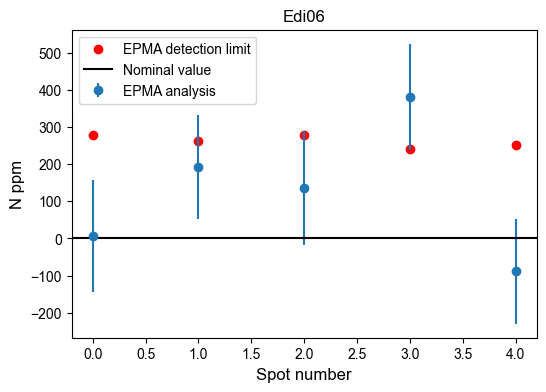

In [21]:
N_by_method_sorted = N_by_method.sort_values("method").reset_index()

plt.errorbar(
    x=N_by_method_sorted.index, 
    y=N_by_method_sorted["N wt"] * 10000, 
    yerr=N_by_method_sorted["N stdev abs"] * 10000,
    marker="o",
    linestyle="",
    label="EPMA analysis"
    )

plt.scatter(
    x=N_by_method_sorted.index,
    y=N_by_method_sorted["N detlim"]*10000,
    color="r",
    label="EPMA detection limit",
    zorder=0
)
# plt.xticks(range(0,13))
# plt.ylim(0, 2000)
plt.ylabel("N ppm")
plt.xlabel("Spot number")

plt.axhline(y=0, color="k", label="Nominal value")
plt.legend()
plt.title(sample)


In [22]:
n_summary = {}
for nm in results["wtdata"].keys():
    n_summary[nm] = results["wtdata"][nm].loc["N", ["average", "stdev"]]
    n_summary[nm].rename({"average": "N wt% average"}, inplace=True)
    n_summary[nm].rename({"stdev": "stdev (multiple measurements)"}, inplace=True)
    n_summary[nm]["typical stdev on individual measurement"] = (
        n_summary[nm]["N wt% average"] * 
        typical_kratios
        .loc[nm, "Stdev % (relative)"]/100
    )

pd.concat(n_summary, axis=1).transpose()

,N wt% average,stdev (multiple measurements),typical stdev on individual measurement
Edi06_1_base,0.000000,0.000000,0.000000
Edi06_2_bg,0.010434,0.014954,0.050995
Edi06_3_bg_apf,0.012571,0.018015,0.061450


In [23]:
results_detlim["wtdata"][f"{sample}_3_bg_apf_detlim"].loc["N", :]

0          0.027935
1          0.026248
2          0.027707
3          0.024071
4          0.025276
average    0.026247
stdev      0.001632
minimum    0.024071
maximum    0.027935
Name: N, dtype: float64

In [24]:
wt_pct_summary_table = pd.concat(
    {k: v[["average", "stdev"]] for k, v in results["wtdata"].items()},
    axis=1
    ).round(3)

wt_pct_summary_table


Edi06_1_base       Edi06_2_bg        Edi06_3_bg_apf       
                 average stdev    average  stdev        average  stdev
wt% element                                                           
Si                23.155   0.0     23.155  0.000         23.155  0.000
Al                 7.739   0.0      7.739  0.000          7.739  0.000
Ca                10.639   0.0     10.639  0.000         10.639  0.000
Mg                 5.614   0.0      5.614  0.000          5.614  0.000
Fe                 6.087   0.0      6.087  0.000          6.087  0.000
Mn                 0.265   0.0      0.265  0.000          0.265  0.000
K                  0.173   0.0      0.173  0.000          0.173  0.000
Na                 1.333   0.0      1.333  0.000          1.333  0.000
N                  0.000   0.0      0.010  0.015          0.013  0.018
P                  0.085   0.0      0.085  0.000          0.085  0.000
Cl                 0.003   0.0      0.003  0.000          0.003  0.000
Cr                 0.034   0.0      0.034  0.000          0.034  0.000
Ru                 0.009   0.0      0.009  0.000          0.009  0.000
O                 44.528   0.0     44.528  0.000         44.528  0.000
TOTAL             99.664   0.0     99.675  0.015         99.677  0.018

In [25]:
suffix_list = ["1_base", "2_bg", "3_bg_apf"]

summary, details = compile_n_summary(
    suffix_list, results, results_detlim, sampledata, datalist, summary_tables, samples
)

summary.round(3)

Sample: Edi06, suffix: 1_base


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,Edi06,Edi06_100nA_30um_1,0.0,100.0,0.0,NaN,0.0119
1,Edi06,Edi06_100nA_30um_2,0.0,100.0,0.0,NaN,0.0119
2,Edi06,Edi06_100nA_30um_3,0.0,100.0,0.0,NaN,0.0118
3,Edi06,Edi06_100nA_30um_4,0.0,100.0,0.0,NaN,0.0117
4,Edi06,Edi06_100nA_30um_5,0.0,100.0,0.0,NaN,0.0119


Sample: Edi06, suffix: 2_bg


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,Edi06,Edi06_100nA_30um_1,0.000606,2062.87,0.012501,0.023189,0.0119
1,Edi06,Edi06_100nA_30um_2,0.015949,73.28,0.011687,0.021788,0.0119
2,Edi06,Edi06_100nA_30um_3,0.011366,111.99,0.012729,0.022999,0.0118
3,Edi06,Edi06_100nA_30um_4,0.031629,37.43,0.011839,0.019979,0.0117
4,Edi06,Edi06_100nA_30um_5,-0.007380,158.14,-0.011671,0.020981,0.0119


Sample: Edi06, suffix: 3_bg_apf


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,Edi06,Edi06_100nA_30um_1,0.000731,2062.87,0.015080,0.027935,0.0119
1,Edi06,Edi06_100nA_30um_2,0.019216,73.37,0.014099,0.026248,0.0119
2,Edi06,Edi06_100nA_30um_3,0.013694,112.04,0.015343,0.027707,0.0118
3,Edi06,Edi06_100nA_30um_4,0.038105,37.60,0.014327,0.024071,0.0117
4,Edi06,Edi06_100nA_30um_5,-0.008890,158.18,-0.014062,0.025276,0.0119


1_base                                                                                                 2_bg                                                                                             3_bg_apf                                                                                     
       N wt% (average) N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average) N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average) N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots)
sample                                                                                                                                                                                                                                                                                                               
Edi06              0.0      NaN           0.012                            0.0                          0.0            0.01    0.022           0.012                          0.007                        0.015           0.013    0.026           0.012                          0.009                        0.018

In [26]:
summary.to_csv("../data/processed/basaltic_glasses/N_summary_Edi06.csv")

# Use of Edi06 as a blank material

Look at the cps at the peak position

In [27]:
[s.peak.loc[0, "raw_cps"] for s in myspot]

[64.32272727272728,
 65.59090909090912,
 63.96363636363642,
 64.92727272727272,
 63.640909090908984]

That's the raw cps. 

In [28]:
myspot[0].peak

,element,pos,net_cps,stdev_net_cps,dl_ppm,kraw_pcnt,time,raw_cps,kraw_stdev_pcnt,stdev_raw_cps,kraw_apf_pcnt,kraw_stdev_apf_pcnt
0,N,146.709,-20.8,100.0,119.0,0.0,120.0,64.322727,100.00022,0.732136,0.0,100.065521
1,N,146.709,-246.6,100.0,233.0,0.0,2.0,81.453571,100.00022,6.381754,0.0,100.000220


In [29]:
print(np.mean([s.peak.loc[0, "raw_cps"] for s in myspot]))
(np.std([s.peak.loc[0, "raw_cps"] for s in myspot]))

64.48909090909089


0.6970220006725217

So the typical raw cps in those Edi06 analyses was 64.5(7)

This value will be used for comparison to curve-fit derived backgrounds in subsequent notebooks.